# NLP2022: Assignment 1

### -Avirup Das (MDS202013)

In [ ]:
# Importing necessary packages
import os, re, json, math, nltk, pickle, spacy, string
import pandas as pd
import numpy as np
from tqdm import tqdm
from operator import itemgetter
from IPython.display import display
from collections import OrderedDict
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

'''
# Installing fasttext for language detection and downloading model
!pip install -q fasttext
!wget -q "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
import fasttext
'''

# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Setting paths
path_to_json = 'pdf_json/'
drive_directory = 'drive/MyDrive/Data/NLP2022/'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /content/drive


In [ ]:
%%time
# Unzipping json files from drive into colab memory
!unzip drive/MyDrive/Data/NLP2022/pdf_json.zip > /dev/null

CPU times: user 397 ms, sys: 71.7 ms, total: 469 ms
Wall time: 54.2 s


## Task 1: Extracting text content from json files and creating a text corpus

In [ ]:
def extract_text(filename):
    '''
    Extract the text from the file name (json file) and
    index the content from paper_id, title, abstract and body_text fields
    Retuns - text of title, abstract and bodt_text
    '''

    file = open(filename)
    body_text = ""
    abstract = ""
    title = ""
    paper_id = ""

    paper_content = json.load(file)

    #get the paper_id
    if 'paper_id' in paper_content:
        paper_id = paper_content['paper_id']
        
    #get the title, if available
    if 'title' in paper_content['metadata']:
        title = paper_content['metadata']['title']
    #get abstract.text, if available
    if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract = abstract + abs['text']
    if 'body_text' in paper_content:
        for bt in paper_content['body_text']:
            body_text = body_text + bt['text']
    file.close()
   
    return (title + ' ' + abstract + ' ' + body_text + ' ').lower()

Text would be extracted from each json file and added to the corpus. Documents in the corpus would be separated by a new-line character ('\n'). So we would also check for the presence of '\n' inside each document using regex, if present we remove that from the document before appending to the corpus.

In [ ]:
%%time

# Reading all filenames of the json files
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

'''
Function to create a text corpus for a given set of files as input.
In the text corpus, each document will be represented as a text in each line. 
'''
def create_corpus(path_to_json, files):
  # Creating corpus till the last document
  corpus = '\n'.join(extract_text(path_to_json+i) if re.search('\n',extract_text(path_to_json+i))
                     is None else re.sub('\n','', extract_text(path_to_json+i))
                      for i in files[:-1])
  
  if re.search('\n', extract_text(path_to_json+files[-1])) is not None:
    return corpus + re.sub('\n','', extract_text(path_to_json+files[-1]))
  # Adding the last document to the corpus without \n at the end
  return corpus + extract_text(path_to_json+files[-1])

# generating corpus
corpus = create_corpus(path_to_json, json_files)

# saving corpus
with open(drive_directory+'corpus.txt','w') as f:
  f.write(corpus)

CPU times: user 2min 5s, sys: 18.5 s, total: 2min 23s
Wall time: 3min 9s


## Task 2: Pre-processing steps

<b> Removing non-English documents from the corpus: </b> 

Since most of the documents are in English, keeping documents of other languages in the corpus will give rise to additional complexities while we handle the language generation model later. Hence, for simplicity, we would remove all non-English documents as a pre-processing step. <br><br>

<b> Pre-processing steps: </b>
- Expanding contractions: Changing contractions like aren't, would've, can't, etc. to are not, would have, can not, respectively to obtain a proper vocabulary.

- Removing URLs, HTML tags and email-IDs since they should not be included in the vocabulary

- Removing paranthesis and anything in paranthesis with the assumption that anything in paranthesis is additional information and hence can be ignored. Note that this step would also remove citation references (eg: [3])

- Removing apostrophe and quotes since they can be problematic during tokenization. 

- Removing all special characters, digits and single letters (except 'a') and then encoding followed by decode in ASCII to remove all invalid characters.

- Tokenization: We tokenize the corpus, remove stopwords and any other invalid tokens (for eg: '$\sim\sim\sim$afgh~l$') which would have otherwise crept into the corpus and then lemmatize the tokens.

<br><br>
**Note:** We perform pre-processing in batches of 6000 documents (10 batches) to avoid memory overflow and write the batches to disk.

### Non-English document removal

In [ ]:
with open(drive_directory+'corpus.txt','r') as f:
  corpus = f.read()

In [ ]:
# Loading Fasttext model for language identification
class LangDetect:
  def __init__(self):
    try:
      path_to_pretrained_model = 'lid.176.bin'
      self.model = fasttext.load_model(path_to_pretrained_model)
    except:
      print('Could not load Fasttext model')

  def predict_eng(self, corpus):
    eng_doc_preds = sum(self.model.predict(corpus.split('\n'))[0],[])
    return eng_doc_preds

# Function to return English corpus
def generate_eng_corpus(corpus, save_corpus=True):
  # Obtaining predictions of language detection
  eng_doc_preds = LangDetect().predict_eng(corpus)

  # Obtaining indices of English documents
  corpus_docs = corpus.split('\n')
  eng_corpus = [corpus_docs[i] for i,res in enumerate(tqdm(eng_doc_preds)) if res.split('__')[2]=='en']
  print(f'No. of English documents = {len(eng_corpus)}')

  # Obtaining English corpus and saving it
  if save_corpus:
    with open(drive_directory+'eng_corpus.txt','w') as f:
      f.write('\n'.join(eng_corpus))

  return '\n'.join(eng_corpus)

In [ ]:
%%time
eng_corpus = generate_eng_corpus(corpus)

100%|██████████| 56527/56527 [00:00<00:00, 931582.30it/s]


No. of English documents = 54869
CPU times: user 3min 43s, sys: 33 s, total: 4min 16s
Wall time: 4min 21s


### Pre-processing

In [ ]:
with open(drive_directory+'eng_corpus.txt','r') as f:
  eng_corpus= f.read()

In [ ]:
def rem_quote(corpus):
  # Remove apostrophe (\') and quotes
  return re.sub('[\"\']', '', re.sub('\'', '', corpus))

def rem_contractions(corpus):
  '''
    Removes all contractions from the corpus
  '''
  # Removing specific contractions
  corpus = re.sub(r"won\'t", " will not ", corpus)
  corpus = re.sub(r"can\'t", " can not ", corpus)
  corpus = re.sub(r"e.g.", " example ", corpus)
  corpus = re.sub(r"i.e.", " that is ", corpus)

  # Removing general contractions
  corpus = re.sub(r"n\'t", " not ", corpus)
  corpus = re.sub(r"\'re", " are ", corpus)
  corpus = re.sub(r"\'s", " is ", corpus)
  corpus = re.sub(r"\'d", " would ", corpus)
  corpus = re.sub(r"\'ll", " will ", corpus)
  corpus = re.sub(r"\'t", " not ", corpus)
  corpus = re.sub(r"\'ve", " have ", corpus)
  corpus = re.sub(r"\'m", " am ", corpus)

  return corpus

def rem_url(corpus):
  '''
  Remove all urls from the corpus. Searching for the regex pattern http(s)://
  or http(s):\\ followed by any set of characters unless it is a blank space (' '),
  newline ('\n'), tab-space ('\t'), any white space ('\s') or ending brackets ')'
  '''
  regex = re.compile(r'https?:/\/\.*[^\r\n\s\t\)]*')
  corpus = re.sub(regex, '', corpus)

  # Removing email IDs
  return re.sub(re.compile(r"\S*@\S*\s?"),'', corpus)

def rem_brackets(corpus):
  '''
  Remove parenthesis and all characters appearing between them (if any).
  Also remove citations which are in third brackets (eg: [3])
  '''
  regex = re.compile(r'[\[\(]+[^\n\[\(]*[\)\]]+')
  return re.sub(regex, '', corpus)

def rem_nums_chars(corpus):
  '''
   Remove all special characters, digits and single letters (except 'a')
   and then encode and decode in ASCII to remove all invalid characters
  '''
  corpus = re.sub(r'''[\[\]\(\)\{\}[.!?'",:;#$%&><=*\\\/\+\-\@]''', ' ', corpus)
  corpus = re.sub(r'[0-9?]', ' ', corpus)
  corpus = re.sub(r' [b-zB-Z] ', ' ', corpus)
  corpus = corpus.encode("ascii", "ignore")
  return corpus.decode()

def tokenization(corpus):
  '''
    Accepts corpus, removes stop-words, performs lemmatization
    and returns word-tokens
  '''
  tokens = word_tokenize(corpus)
  # tokens = list(filter(lambda token: token not in string.punctuation, tokens))
  stop_removed = rem_stopwords(tokens)
  lemm_corpus = lemm_tokens(stop_removed)
  return lemm_corpus

def rem_stopwords(tokens):
  '''
   Accepts tokens and removes stop-words, single characters,
   numbers and some other invalid tokens which would have 
   otherwise crept into the vocabulary
  '''
  sp = spacy.load('en_core_web_sm')
  stopwords = sp.Defaults.stop_words
  output = [i.replace('~','').replace('|','') for i in tokens if (i not in stopwords
                                              and len(re.sub(r"[^a-zA-Z0-9]","",i))>1)]
  return output

def pos_tagger(tag):
  if tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return None
  

def lemm_tokens(tokens):
  # Accepts tokens and performs lemmatization
  '''
  wl = WordNetLemmatizer()
  lemm_corpus = [wl.lemmatize(token.lower(), pos=penn_tree_to_morphy(tag)) for token, tag in pos_tag(tokens)]
  return lemm_corpus
  '''
  nltk_tag = pos_tag(tokens)
  wordnet_tag = map(lambda x: (x[0], pos_tagger(x[1])), nltk_tag)
  wl = WordNetLemmatizer()
  lemm_corpus = [token if tag is None else wl.lemmatize(token, tag) for token, tag in wordnet_tag]
  return lemm_corpus

def preprocess(corpus):
  # Defining our sequence of pre-processing steps
  corpus = rem_contractions(corpus)
  corpus = rem_url(corpus)
  corpus = rem_brackets(corpus)
  corpus = rem_quote(corpus)
  corpus = rem_nums_chars(corpus)
  return corpus

def preprocess_batch(corpus, batch_size=6000):
  '''
   Pre-processing the whole corpus in batches to avoid memory-overflow
   and writing batches to disk
  '''
  docs = corpus.split('\n')
  n_batches = math.ceil(len(docs)/batch_size)
  for i in range(n_batches):
    batch_begin= batch_size*i
    batch = docs[batch_begin:batch_begin+batch_size]
    batch = preprocess('\n'.join(batch))
    batch = tokenization(batch)
    with open(drive_directory+f'token_batch_{i+1}', 'wb') as f:
      pickle.dump(batch, f)
    print(f'Pre-processing {i+1}-th batch: Done')

In [ ]:
%%time
preprocess_batch(eng_corpus)

Pre-processing 1-th batch: Done
Pre-processing 2-th batch: Done
Pre-processing 3-th batch: Done
Pre-processing 4-th batch: Done
Pre-processing 5-th batch: Done
Pre-processing 6-th batch: Done
Pre-processing 7-th batch: Done
Pre-processing 8-th batch: Done
Pre-processing 9-th batch: Done
Pre-processing 10-th batch: Done
CPU times: user 2h 50min 34s, sys: 1min 32s, total: 2h 52min 7s
Wall time: 2h 52min 32s


## Task 3: Forming frequency table and calculating average value of $\alpha$

In [ ]:
# Function to read tokens in batches and form vocab
def create_vocab(token_name, save_vocab=False):
  # Reading tokens
  token_files = [tok_batch for tok_batch in os.listdir(drive_directory) if tok_batch.startswith(token_name)]
  tokens = []
  for i in token_files:
    with open(drive_directory+i, 'rb') as f:
      tokens.extend(pickle.load(f))

  '''
   Forming vocabulary as a dictionary (vocab) and forming lists
   T and M which contain the token an vocablary counts respectively
   at an interval of 10000 tokens
  '''
  word_count, vocab, T, M = 0, {}, [], []
  for i in tokens:
    word_count +=1
    vocab[i] = vocab.get(i,0) + 1
    if word_count % 10000 == 0:
      T.append(word_count)
      M.append(len(vocab.keys()))

  # Sorting vocabulary
  vocab = OrderedDict(sorted(vocab.items(), key=lambda x: (-x[1],x[0]), reverse=False))

  # Calculating ranks of words
  rank = 1
  for i in vocab.keys():
    vocab[i] = [vocab[i], rank]
    rank+=1

  print('Vocab size = ', len(vocab.keys()))

  # Saving vocabulary as json
  if save_vocab:
    with open(drive_directory+'vocab_file.json', 'w') as f:
      f.write(json.dumps(vocab))
  
  return vocab, T, M

In [ ]:
# Generating vocabulary
%%time
vocab, T, M = create_vocab('token_batch', save_vocab=True)

Vocab size =  629005
CPU times: user 1min 38s, sys: 10.6 s, total: 1min 48s
Wall time: 1min 53s


In [ ]:
# Plot frequncy vs rank and display frequency-rank table
def plot_freq_rank(vocab):
  # Converting to dataframe for ease of plotting
  df = pd.DataFrame(vocab.items(), columns=['word', 'rank-freq'])
  df = pd.concat([df['word'],pd.DataFrame(df['rank-freq'].tolist(), columns=['frequency','rank'])], axis=1)
  print('Rank and Frequencies of words:')
  display(df)

  plt.figure(figsize=(12,8))
  plt.plot(df['rank'][:500], df['frequency'][:500])
  plt.xlabel('Rank')
  plt.ylabel('Frequency')
  plt.title('Rank-Frequency Distribution')

  return df

Rank and Frequencies of words:


,word,frequency,rank
0,example,1478178,1
1,patient,875531,2
2,cell,786831,3
3,study,691317,4
4,virus,534672,5
...,...,...,...
629000,zzia,1,629001
629001,zzle,1,629002
629002,zzq,1,629003
629003,zzzln,1,629004


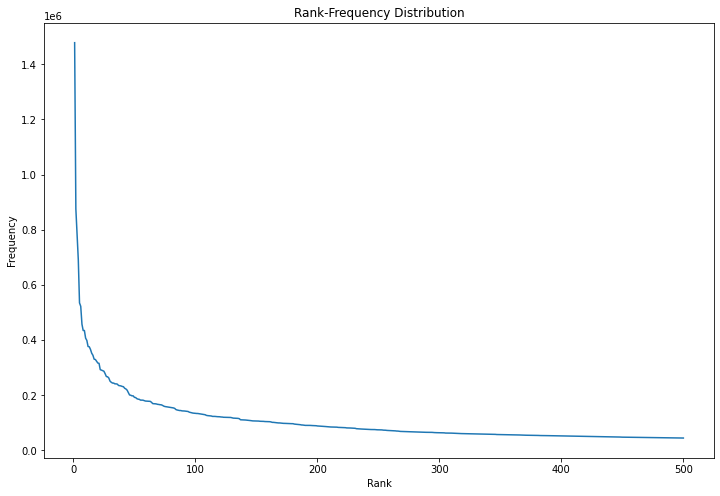

In [ ]:
df = plot_freq_rank(vocab)

### Estimating $\alpha$: 

According to **Zipf's law**: $f(r)\propto \dfrac{1}{r^{\alpha}} \ \Rightarrow f(r) = \dfrac{C}{r^{\alpha}} \qquad \ldots (i)$

Now putting $r=1$ we get: $C= f(1) \qquad \ldots (ii)$

From $(i)$ and $(ii)$ we get: $f(r) = \dfrac{f(1)}{r^\alpha} \ \Rightarrow \alpha = \dfrac{ln(f(1)) - ln(f(r))}{ln(r)}$ 

In [ ]:
%%time
def estimate_alpha(df):
  # Constant of proportionality equals highest frequency
  C = df['frequency'][0]
  # Estimating alpha from rank 2 onwards
  alpha = [(np.log(C) - np.log(df['frequency'][i]))/np.log(df['rank'][i]) for i in range(1,df.shape[0])]
  # Retuning average value of alpha
  return np.mean(alpha)

alpha = estimate_alpha(df)
print(f'Average value of alpha= {alpha}')

Average value of alpha= 1.060666177751599
CPU times: user 12.9 s, sys: 54 ms, total: 12.9 s
Wall time: 12.9 s


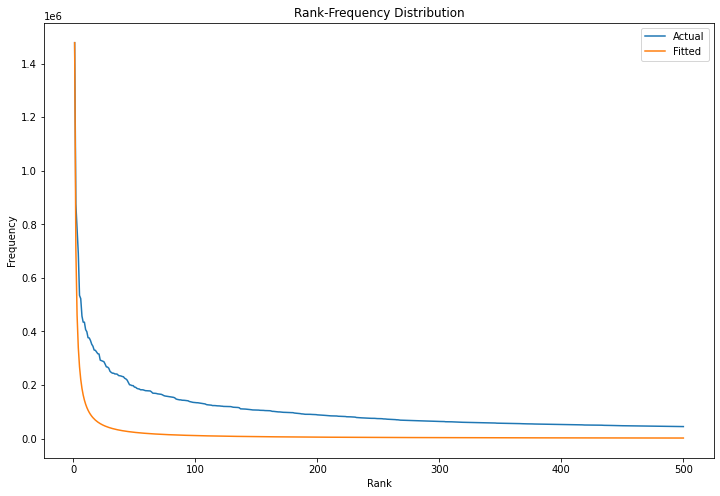

In [ ]:
# Plot fitted vs actual frequency
def plot_fit(df, alpha):
  plt.figure(figsize=(12,8))
  plt.plot(df['rank'][:500], df['frequency'][:500])
  plt.plot(df['rank'][:500], df['frequency'][0]/(df['rank'][:500]**alpha))
  plt.legend(['Actual','Fitted'])
  plt.xlabel('Rank')
  plt.ylabel('Frequency')
  plt.title('Rank-Frequency Distribution')

plot_fit(df, alpha)

The distribution was moderately fitted

## Task 4: Token vs vocab
The lists T and M contain the token an vocablary counts respectively at an interval of 10000 tokens. Now, to estimate the parameters of `Heap's law estimate`:
\begin{align*}
M &= k\ T^b \ \Rightarrow log_{10}(M) = log_{10}(k) + b\ log_{10}(T) 
\end{align*}
So two points of $T$ and $M$ would be sufficient which we are taking at token counts of 10000 and 50000 which would be used to estimate the values of $k$ and $b$. Using these we would estimate the values of $M$ for each value of $T$

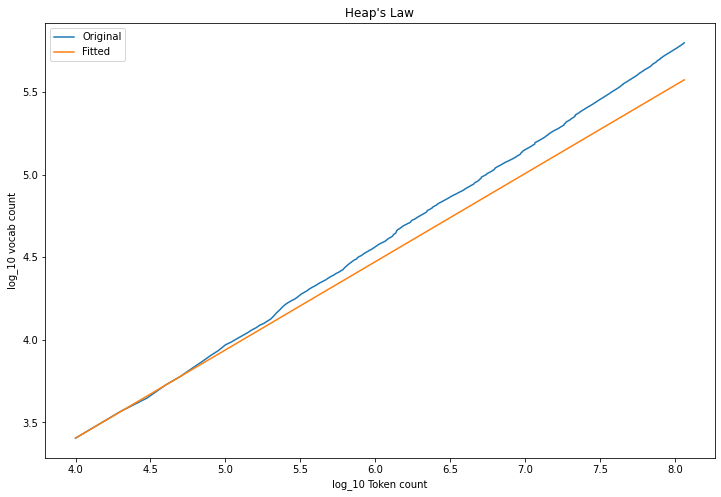

In [ ]:
# Function to estimate the parameters of Heap's law
def heap_estimate(T, M):
  logT, logM = np.log10(T), np.log10(M)
  x1, x2, y1, y2 = logT[0], logT[4], logM[0], logM[4]

  # Estimating b
  b = (y2-y1)/(x2-x1)
  # Estimating k
  logk = y2 - (b*x2)

  M_est = [(logk + (b*i)) for i in logT]
  return M_est

# Plot original and fitted estimates for Heap's Law
def plot_fit_heap(T, M, M_est):
  plt.figure(figsize=(12,8))
  plt.plot(np.log10(T), np.log10(M))
  plt.plot(np.log10(T), M_est)
  plt.xlabel('log_10 Token count')
  plt.ylabel('log_10 vocab count')
  plt.legend(['Original','Fitted'])
  plt.title("Heap's Law")

M_est = heap_estimate(T, M)
plot_fit_heap(T, M, M_est)